# CEE 598: Uncertainty Quantification
## Assignment Five
### Noah Garfinkle (garfink2@illinois edu)
### 16 April 2020

## Imports and Set Up

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pytest
import chaospy as cp
import pandas as pd

## References

- https://chaospy.readthedocs.io/en/master/tutorial.html


## Task One

Using the three-term recurrence relation, write a generic code that evaluates the $n$-th order one-dimensional Hermite and Legendre polynomials, denoted by $P_n(x)$, at a prescribed numerical value for $x$.  The code can be written in the form of a single function that is called with a prescribed type of polynomial (either Hermite or Legendre).  Name your function evaluate_1D_polynomial.  So, the function will be called as follows

**evaluate_1D_polynomial(x,n,polynomial_type)**.

Using this function, plot the Hermite and Legendre polynomials of order ${0,1,2,3}$.  For Hermite polynomials, set the plotting range $x$ to be $[-3,3]$.

## Task Two

Multi-dimensional polynomial bases are just the product of one-dimensional polynomials.  Based on your one-dimensional polynomial code, **evaluate_1D_polynomial**, write a code that evaluates the $i$-th $d$-dimensional Hermite or Legendre polynomial, denoted by $\Psi_i(x)$, at a given numerical vector sample $x={x_i}_{i=1}^d$.  The function will be called as follows

**polynomial_value = evaluate_multiD_polynomial(x,d,i,polynomial_type)**

Using this function, generate the (surface) plots of 2D Hermite and Legendre polynomials with $i={0,1,2,3}$.  For Hermite polynomials, set the plotting range of $x_1$ and $x_2$ to be $[-3,3]$.

### Note

For the relationship between a multi-dimensional index, $i$, and its corresponding combination of one-dimensional degrees, e.g. (2,1,0,1), you could use the convention shown on Slide 6 of March 31 Lecture.  

## Task Three

In this code verification task, verify your codes by testing whether it can separately recover the following two target functions (intentionally chosen to be polynomial):

$$f(x_1,...,x_2)=6+2x_1^2+0.2x_1^3+2.3x_1x_2-1.5x_2^2-0.8x_3$$

$$g(y_1,y_2)=-15+0.05y_2^2+3.2y_1y_2+0.3y_2^2$$

Consider all the 3 $x$ variables to be standard normal and the 2 $y$ variables to be uniform random variables in $[0,1]$, use the corresponding orthogonal polynomials.  To do the verification, use multidimensional quadrature using tensor product.  For 1D quadrature rules, use Gauss-Hermite quadrature points for normal random variables and Gauss-Legendre quadrature points for uniform random variables.  These quadrature points and their weights can be easily found on the Internet.  You should choose the number of quadrature points and explain your choices.

## General Solution Approach

Per the assignment guidelines, I have ultimately chosen approach (3), utilizing open-source codes to perform tasks 1 and 2, and verified using task 3.  I had initially attempted approach (2), but am most satisfied with the verificiation of task 3 utilizing approach (3).  For the library, I have chosen to use the Python library ChaosPy, which I found through online searches and comparisons of available options.  As seen in the code below, the approach for Chaospy is relatively clean and straightforward, requiring only a few hours of review and practice to implement successfully with required variations.  In the spirit of this assignment, I have also written several helper functions included with this assignment, which I found useful in understanding the results produced by ChaosPy and in comparing my results to those expected per task 3.  These functions were particularly important for the first reason, as the danger of applying an unknown third-party library is that it is often difficult to understand if it is functioning correctly and in the intended way.

Per slide 6 of lecture 17, we consider the general approach to be:
1. Choose the polynomial type
2. Write the polynomial representation for parameters
3. Pick the polynomial order for response
4. Write the polynomial representation for response
5. Calculate the unknown coefficients

$$u_i = \sum_{q=1}^{N_q} f(\bar{x}^q)\psi_i(\bar{x}^q)w^q$$

I have simplified most of these steps within wrappers for the ChaosPy library, which still require inputs for (1) the polynomial type and (3) the polynomial order for the response.  I have written the code to be easily modified to take in arbitrary simulations for the systems being modeled, but have also written my wrappers to directly input matrix representations of the polynomial functions for easy comparison.

While ChaosPy supports a vast variety of polynomial types, per the problem prompt I have focused on normal distributions (evaluated using Hermite polynomials) and uniform distributions (evaluated using Legendre polynomials).  Because the ChaosPy library is well established, I first solved for the multi-dimensional polynomial, and then bulit the ability to indvidually extract out and filter the one-dimensional polynomials.  I feel that this approach most cleanly allows utilization of the library.  Runtime is very fast for the examples of case three.

In [2]:
# Use ChasosPy to define the distributions for the problem.  Multiple distributions are supported by defualt.
distribution_x = cp.J(cp.Normal(),cp.Normal(),cp.Normal())
distribution_y = cp.J(cp.Uniform(0,1),cp.Uniform(0,1))

For simplicity in comparing results, I have chosen to create a data structure for storing polynomials. The datastructure, contained within a Pandas DataFrame, has a column of coefficients, followed by an arbitrary number of numbered columns representing variables (for instance $x_1$), the value of which is the power to which this coefficient should be taken for the given term, scaled by the row's coefficient.

In [3]:
coefs_x = [6,2,0.2,2.3,-1.5,-0.8]
x1_x = [0,2,3,1,0,0]
x2_x = [0,0,0,1,2,0]
x3_x = [0,0,0,0,0,1]
df_x = pd.DataFrame({"Coefficient":coefs_x,0:x1_x,1:x2_x,2:x3_x})
df_x

,Coefficient,0,1,2
0,6.0,0,0,0
1,2.0,2,0,0
2,0.2,3,0,0
3,2.3,1,1,0
4,-1.5,0,2,0
5,-0.8,0,0,1


In [4]:
coefs_y = [-15,0.05,3.2,0.3]
y1_y = [0,0,1,0]
y2_y = [0,2,1,2]
df_y = pd.DataFrame({"Coefficient":coefs_y,0:y1_y,1:y2_y})
df_y

,Coefficient,0,1
0,-15.00,0,0
1,0.05,0,2
2,3.20,1,1
3,0.30,0,2


## Helper Functions for ChaosPy

In [5]:
"""
Takes the dataframe representation of coefficients and variable orders and allows this to be treated like
an equation, taking inputs and returning the evaluation.  Very simple but I think a pretty clean
way to represent the models used in task three. Most importantly, makes it much easier to evaluate
ChaosPy polynomials in my opinion.

Inputs:
coefsDF (Pandas DataFrame) -> a data structure I created for this assignment where the first column
                              is the coefficient of each term, and each subsequent numbered column
                              is a variable index
varsArray (list or numpy array) -> the coordinates at which the function is being evaluated

Returns:
valueToReturn (float) -> The value of the function represented by coefsDF at the coordinates represented
                        by varsArray
"""
def matrixToEquation(coefsDF,varsArray):
    valueToReturn = 0.0
    for i,row in coefsDF.iterrows():
        rowValue = row["Coefficient"]
        for j,var in enumerate(varsArray):
            rowValue *= np.power(var,row[j])
        valueToReturn += rowValue
    return valueToReturn

In [6]:
# this is kludgy, but pass the two coefficinent matrices and an array of variables where
# the place which is (min,max) is the study (non-fixed) variable and the other values are fixed
def plotComparison(correctCoefs,generatedCoefs,arr,title='',nSamples=100):
    correctEvaluations = []
    generatedEvaluations = []
    indexOfVariable = [i for i in range(len(arr)) if type(arr[i]) == tuple][0]
    lowerBound = arr[indexOfVariable][0]
    upperBound = arr[indexOfVariable][1]
    varValues = np.linspace(lowerBound,upperBound,nSamples)
    for varValue in varValues:
        variableInput = []
        for varLoc,varVal in enumerate(arr):
            if varLoc == indexOfVariable:
                variableInput.append(varValue)
            else:
                variableInput.append(varVal)
        correctEvaluation = matrixToEquation(correctCoefs,variableInput)
        generatedEvaluation = matrixToEquation(generatedCoefs,variableInput)
        correctEvaluations.append(correctEvaluation)
        generatedEvaluations.append(generatedEvaluation)
    fig,ax = plt.subplots(figsize=(10,5))
    ax.plot(varValues,correctEvaluations,label="Correct")
    ax.scatter(varValues,generatedEvaluations,label="Test",marker="*",color="red",alpha=0.5)
    ax.set_title(title)
    ax.legend()

In [7]:
"""
Creates a pretty-print string representation of the polynomial represented by the pandas dataframe,
written to look nice in LaTex.  The cutoff will drop (from printing, not from analyzing) any coefficient
with an absolute value less than the cutoff.  Coefficients are rounded for printing based upon rounding.
"""
def convertDFGeneratedToEquation(df_Generated,variableName="X",cutoff=0.001,rounding=3):
    df_Generated_Filtered = df_Generated[np.abs(df_Generated["Coefficient"]) >= 0.001]
    variables = list(df_Generated.columns)[1:]
    strRepresentation = ""
    for i,row in df_Generated_Filtered.iterrows():
        if row["Coefficient"] >= 0:
            term = f"+{round(row['Coefficient'],rounding)}"
        else:
            term = f"{round(row['Coefficient'],rounding)}"
        for variable in variables:
            if row[variable] != 0:
                term += f"{variableName}_{variable+1}^{int(row[variable])}" # the variable + 1 is to be congruent with the 1-based indexing of the assignment
        strRepresentation += term
    return strRepresentation

In [8]:
"""
This function implements task three directly, with the examples below demonstrating how it can be
used to implement tasks one and two.  

Inputs:
distribution (Pandas DataFrame) -> a data structure I created for this assignment where the first column
                              is the coefficient of each term, and each subsequent numbered column
                              is a variable index
            
simulationDistribution (Pandas DataFrame) -> The same data structure as above to represent the polynomials
                                             being modeled.  Please note that it is very easy to replace this
                                             with an actual simulation, or any generator of choice.
                                        
order (int) -> The order to be evaluated.  As noted in the discussion, order < 2 produces unpredictable results

sampleRule (string) -> The polynomial type, including "gaussian", "gauss_legendre"

Returns:
df_Generated (Pandas DataFrame) -> a data structure I created for this assignment where the first column
                              is the coefficient of each term, and each subsequent numbered column
                              is a variable index
"""
def generatePolynomialSurrogate(distribution,simulationDistribution,order,sampleRule="gauss_legendre"):
    orthogonal_expansion = cp.orth_ttr(order, distribution)
    samples,weights = cp.generate_quadrature(order,distribution,rule=sampleRule)
    solves = np.array([matrixToEquation(simulationDistribution,sample) for sample in samples.T])
    approx_model = cp.fit_regression(orthogonal_expansion, samples, solves)
    nVars = approx_model.exponents.shape[1]
    dataDict = {'Coefficient':approx_model.coefficients}
    for varIndex in range(0,nVars):
        dataDict[varIndex] = approx_model.exponents[:,varIndex]
    df_Generated = pd.DataFrame(dataDict)
    return df_Generated

## Equation X

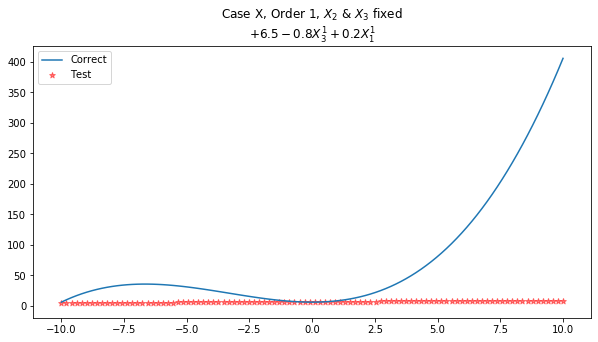

In [9]:
df_Generated = generatePolynomialSurrogate(distribution_x,df_x,1,sampleRule="gaussian")
plotComparison(df_x,df_Generated,[(-10,10),0,0],title=f"Case X, Order 1, $X_2$ & $X_3$ fixed\n${convertDFGeneratedToEquation(df_Generated)}$")

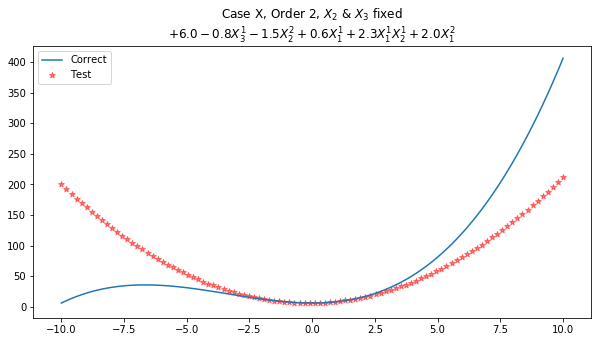

In [10]:
df_Generated = generatePolynomialSurrogate(distribution_x,df_x,2,sampleRule="gaussian")
plotComparison(df_x,df_Generated,[(-10,10),0,0],title=f"Case X, Order 2, $X_2$ & $X_3$ fixed\n${convertDFGeneratedToEquation(df_Generated)}$")

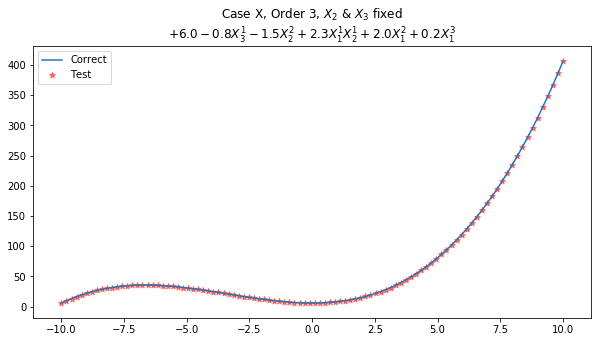

In [11]:
df_Generated = generatePolynomialSurrogate(distribution_x,df_x,3,sampleRule="gaussian")
plotComparison(df_x,df_Generated,[(-10,10),0,0],title=f"Case X, Order 3, $X_2$ & $X_3$ fixed\n${convertDFGeneratedToEquation(df_Generated)}$")

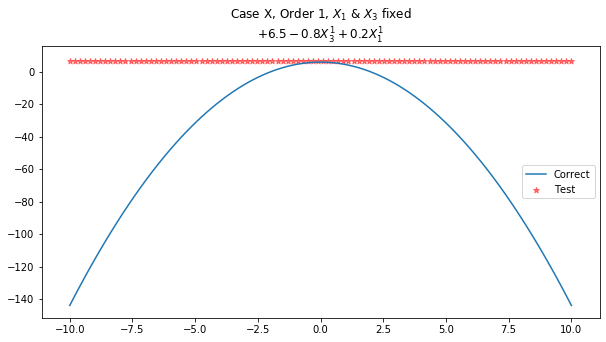

In [12]:
df_Generated = generatePolynomialSurrogate(distribution_x,df_x,1,sampleRule="gaussian")
plotComparison(df_x,df_Generated,[0,(-10,10),0],title=f"Case X, Order 1, $X_1$ & $X_3$ fixed\n${convertDFGeneratedToEquation(df_Generated)}$")

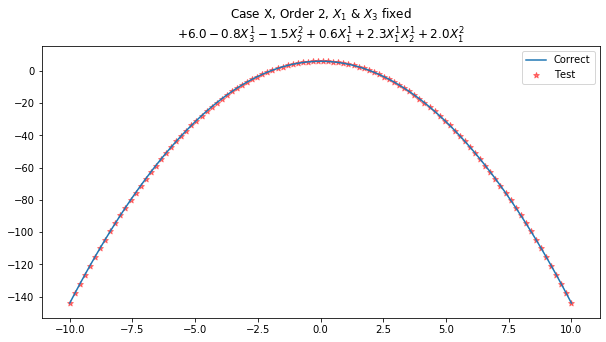

In [13]:
df_Generated = generatePolynomialSurrogate(distribution_x,df_x,2,sampleRule="gaussian")
plotComparison(df_x,df_Generated,[0,(-10,10),0],title=f"Case X, Order 2, $X_1$ & $X_3$ fixed\n${convertDFGeneratedToEquation(df_Generated)}$")

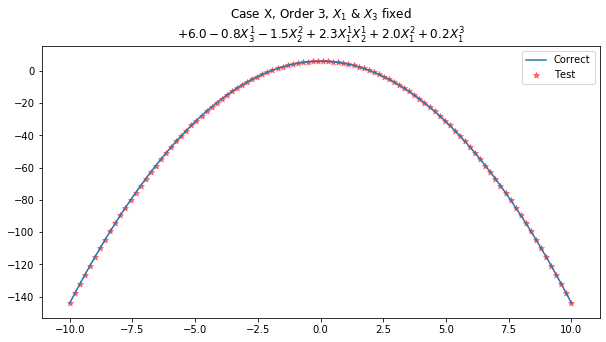

In [14]:
df_Generated = generatePolynomialSurrogate(distribution_x,df_x,3,sampleRule="gaussian")
plotComparison(df_x,df_Generated,[0,(-10,10),0],title=f"Case X, Order 3, $X_1$ & $X_3$ fixed\n${convertDFGeneratedToEquation(df_Generated)}$")

## Equation Y

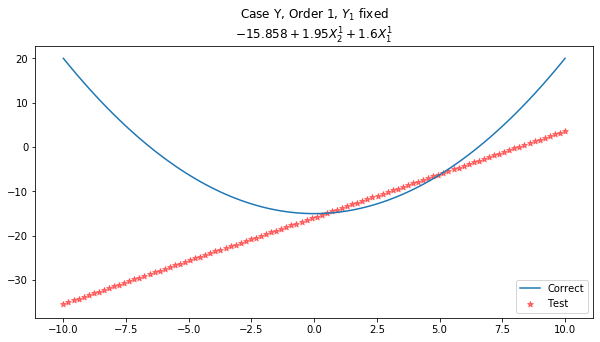

In [15]:
df_Generated = generatePolynomialSurrogate(distribution_y,df_y,1,sampleRule="gauss_legendre")
plotComparison(df_y,df_Generated,[0,(-10,10)],title=f"Case Y, Order 1, $Y_1$ fixed\n${convertDFGeneratedToEquation(df_Generated)}$")

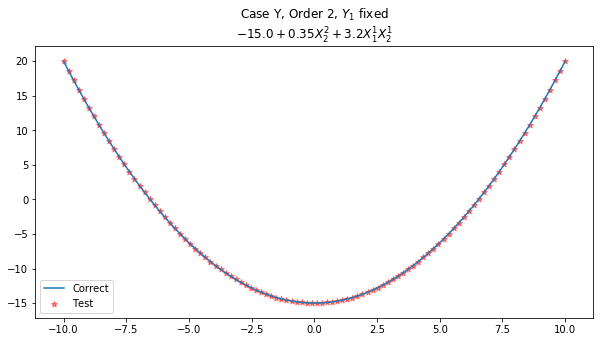

In [16]:
df_Generated = generatePolynomialSurrogate(distribution_y,df_y,2,sampleRule="gauss_legendre")
plotComparison(df_y,df_Generated,[0,(-10,10)],title=f"Case Y, Order 2, $Y_1$ fixed\n${convertDFGeneratedToEquation(df_Generated)}$")

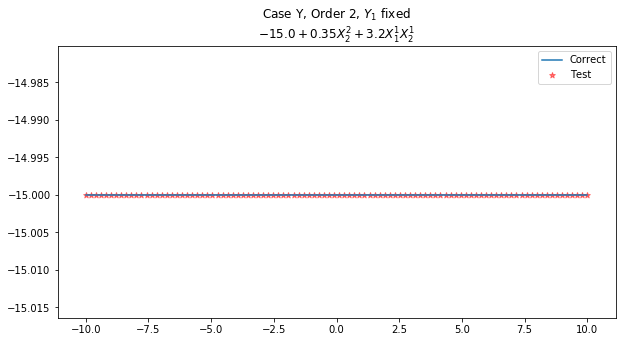

In [17]:
df_Generated = generatePolynomialSurrogate(distribution_y,df_y,2,sampleRule="gauss_legendre")
plotComparison(df_y,df_Generated,[(-10,10),0],title=f"Case Y, Order 2, $Y_1$ fixed\n${convertDFGeneratedToEquation(df_Generated)}$")